### Preliminaries

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import cross_val_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download("averaged_perceptron_tagger")
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\packardbelll\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\packardbelll\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\packardbelll\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\packardbelll\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\packardbelll\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\packardbelll\AppData\Roaming\nltk_data...


True

### Load Data

In [3]:
data = pd.read_csv("train.tsv", sep = "\t")

### Explore Data

In [4]:
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


**Checking for Missing Values**

In [5]:
data.isnull().any()

PhraseId      False
SentenceId    False
Phrase        False
Sentiment     False
dtype: bool

**Plotting Sentiment by its values**

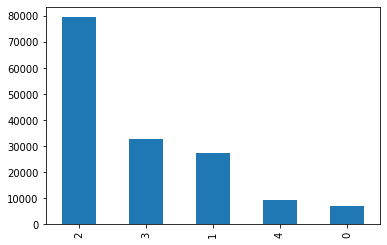

In [6]:
data["Sentiment"].value_counts().plot.bar();

###  Exploratory Data Analysis(EDA)

**Categorizing the values into two categories as "negative" and "positive"**

In [7]:
data["Sentiment"].replace([0,1,3,4], ["negative", "negative", "positive", "positive"], inplace = True)

We want to continue to our analyse with the negative and positive categories. So we will restrict our data to except for the value of "2"

In [8]:
data = data[data["Sentiment"] != 2]

**Our new dataset after dropping the observations with "2"**

In [9]:
data.shape

(76478, 4)

In [10]:
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,negative
21,22,1,good for the goose,positive
22,23,1,good,positive
33,34,1,"the gander , some of which occasionally amuses...",negative
46,47,1,amuses,positive


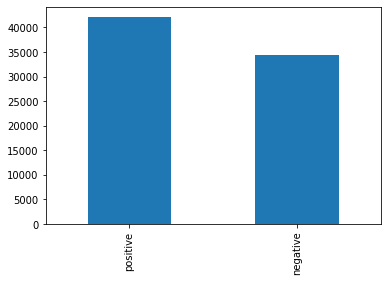

In [11]:
data["Sentiment"].value_counts().plot.bar();

**Creating a new dataframe with only two features, "commment" and "label"**

The values for "comment" will be the values of "Phrase" and for "label" will be the values of "Sentiment" from "data" dataframe.

In [12]:
df = pd.DataFrame()
df["comment"] = data["Phrase"]
df["label"] = data["Sentiment"]

In [13]:
df.head()

,comment,label
0,A series of escapades demonstrating the adage ...,negative
21,good for the goose,positive
22,good,positive
33,"the gander , some of which occasionally amuses...",negative
46,amuses,positive


We can also also drop words that used rarely, when we want make our analyse without words that can be seen as noisy words. We are not dropping any row, but words that are within rows.

In [14]:
#rare_words = pd.Series(' '.join(df['sentences']).split()).value_counts()[-100:]
#df['sentences'] = df['sentences'].apply(lambda x: " ".join(x for x in x.split() if x not in rare_words))

From now on, we will continue to our analyse with that dataframe.

### Text Preprocessing

In [15]:
stop_words = stopwords.words('english')
lem = WordNetLemmatizer()

**Defining a function for all steps**

In [16]:
def cleaning(data):
    #1. Tokenize
    text_tokens = word_tokenize(data)
    
    #2 . Remove Punctuations,numbers and chars
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #3. Remove Stopwords
    tokens_without_sw = [word for word in tokens_without_punc if word not in stop_words]
    
    #4. Lemmatization
    text_cleaned = [lem.lemmatize(word) for word in tokens_without_sw]
    
    #5. Joining
    return " ".join(text_cleaned) 

**Changing the feature of "comment" with cleaned "comment"**

In [17]:
df["comment"] = df["comment"].apply(cleaning)

In [18]:
df.head()

,comment,label
0,A series escapade demonstrating adage good goo...,negative
21,good goose,positive
22,good,positive
33,gander occasionally amuses none amount much story,negative
46,amuses,positive


**Label Encoding**


In order to model regression for our dataset we should encode our "label" feature.

We will transform the values of label into "0" and "1" with the help of LabelEncoder().

In [19]:
from sklearn import preprocessing

In [20]:
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()

In [21]:
# Fit the encoder to the pandas column
le.fit(df['label'])

LabelEncoder()

In [22]:
# Apply the fitted encoder to the pandas column
le.transform(df['label'])

array([0, 1, 1, ..., 0, 0, 1])

In [23]:
df["label"] = le.transform(df['label']) 

In [24]:
df.head()

,comment,label
0,A series escapade demonstrating adage good goo...,0
21,good goose,1
22,good,1
33,gander occasionally amuses none amount much story,0
46,amuses,1


**Break Data Up Into Training And Test Datasets**

In [25]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics

In [26]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df["comment"], df["label"], random_state = 101)

In [27]:
X_train.head()

77893                                           inadvertent
145749                                                 much
132511    ravishing costume production design Joan wacky...
119837                                                  ate
32396     Yet another entry sentimental genre ushered Th...
Name: comment, dtype: object

In [28]:
y_train.head()

77893     0
145749    1
132511    1
119837    0
32396     0
Name: label, dtype: int32

### Vectorization

**Count Vectors**

In [29]:
vectorizer = CountVectorizer()

In [30]:
vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [31]:
X_train_count = vectorizer.transform(X_train)

In [32]:
X_test_count = vectorizer.transform(X_test)

In [33]:
# Get feature names
feature_names = vectorizer.get_feature_names()

In [34]:
# Create data frame
a = pd.DataFrame(X_train_count.toarray(), columns=feature_names)

In [35]:
a.shape

(57358, 13133)

In [36]:
a.head()

,aaa,aaliyah,aan,abagnale,abandon,abandoned,abbass,abbott,abbreviated,abc,...,ziyi,zoe,zombie,zone,zoning,zoolander,zoom,zucker,zwick,zzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**TF-IDF**

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer()

In [38]:
tf_idf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [39]:
X_train_tf_idf = tf_idf.transform(X_train)
X_test_tf_idf = tf_idf.transform(X_test)

In [40]:
# Get feature names
feature_names = tf_idf.get_feature_names()

In [41]:
# Create data frame
b = pd.DataFrame(X_train_tf_idf.toarray(), columns=feature_names)

In [42]:
b.shape

(57358, 13133)

In [43]:
b.head()

,aaa,aaliyah,aan,abagnale,abandon,abandoned,abbass,abbott,abbreviated,abc,...,ziyi,zoe,zombie,zone,zoning,zoolander,zoom,zucker,zwick,zzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sentiment Classification with Machine Learning Models

**Logistic Regression (Count Vector)**

In [44]:
from sklearn.linear_model import LogisticRegression

In [68]:
#Create the Logistic Model
log_model=LogisticRegression()
#Fit the Model
log_model.fit(X_train_count,y_train)
#Predict the test set
y_pred=log_model.predict(X_test_count)
#Evaluate model performance
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
log_model_accuracy_count = model_selection.cross_val_score(log_model, 
                                           X_test_count, 
                                           y_test, 
                                           cv = 10).mean()

print("Count Vectors Logistic Regression Accuracy:", log_model_accuracy_count)

[[7119 1482]
 [1086 9433]]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      8601
           1       0.86      0.90      0.88     10519

    accuracy                           0.87     19120
   macro avg       0.87      0.86      0.86     19120
weighted avg       0.87      0.87      0.87     19120

Count Vectors Logistic Regression Accuracy: 0.8225418410041841


**Logistic Regression (TF-IDF)**

In [46]:
#Create the Logistic Model
log_model=LogisticRegression()
#Fit the Model
log_model.fit(X_train_tf_idf,y_train)
#Predict the test set
y_pred=log_model.predict(X_test_tf_idf)
#Evaluate model performance
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
log_model_accuracy_tf_idf = model_selection.cross_val_score(log_model, 
                                           X_test_tf_idf, 
                                           y_test, 
                                           cv = 10).mean()
print("TF-IDF Logistic Regression Accuracy:", log_model_accuracy_tf_idf)

[[7089 1512]
 [1191 9328]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      8601
           1       0.86      0.89      0.87     10519

    accuracy                           0.86     19120
   macro avg       0.86      0.86      0.86     19120
weighted avg       0.86      0.86      0.86     19120

TF-IDF Logistic Regression Accuracy: 0.8180962343096235


**XGBoost (Count Vector)**

In [47]:
from xgboost import XGBClassifier

In [48]:
#Create the XGBoost Model
xgb_model = XGBClassifier()
#Fit the Model
xgb_model.fit(X_train_count , y_train)
#Predict the test set
y_pred = xgb_model.predict(X_test_count)
#Evaluate model performance
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))
xgb_model_accuracy_count = model_selection.cross_val_score(xgb_model,
                                           X_test_count,
                                           y_test,
                                           cv = 10).mean()
print("Count Vectors XGBoost Accuracy:", xgb_model_accuracy_count)

[[4082 4519]
 [ 659 9860]]
              precision    recall  f1-score   support

           0       0.86      0.47      0.61      8601
           1       0.69      0.94      0.79     10519

    accuracy                           0.73     19120
   macro avg       0.77      0.71      0.70     19120
weighted avg       0.76      0.73      0.71     19120

Count Vectors XGBoost Accuracy: 0.711610878661088


**XGBoost (TF-IDF)**

In [49]:
#Create the XGBoost Model
xgb_model = XGBClassifier()
#Fit the Model
xgb_model.fit(X_train_tf_idf,y_train)
#Predict the test set
y_pred = xgb_model.predict(X_test_tf_idf)
#Evaluate model performance
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))
xgb_model_accuracy_tf_idf = model_selection.cross_val_score(xgb_model,
                                           X_test_tf_idf,
                                           y_test,
                                           cv = 10).mean()
print("TF-IDF XGBoost Accuracy:", xgb_model_accuracy_tf_idf)

[[4043 4558]
 [ 770 9749]]
              precision    recall  f1-score   support

           0       0.84      0.47      0.60      8601
           1       0.68      0.93      0.79     10519

    accuracy                           0.72     19120
   macro avg       0.76      0.70      0.69     19120
weighted avg       0.75      0.72      0.70     19120

TF-IDF XGBoost Accuracy: 0.7036610878661087


**Decision Tree (Count Vector)**

In [51]:
from sklearn.tree import DecisionTreeClassifier

In [53]:
#Create the Decision Tree Model
tree_model = DecisionTreeClassifier()
#Fit the Model
tree_model.fit(X_train_count , y_train)
#Predict the test set
y_pred = tree_model.predict(X_test_count)
#Evaluate model performance
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))
tree_model_accuracy_count = model_selection.cross_val_score(tree_model,
                                           X_test_count,
                                           y_test,
                                           cv = 10).mean()
print("Count Vectors Decision Tree Accuracy:", tree_model_accuracy_count)

[[7185 1416]
 [1040 9479]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      8601
           1       0.87      0.90      0.89     10519

    accuracy                           0.87     19120
   macro avg       0.87      0.87      0.87     19120
weighted avg       0.87      0.87      0.87     19120

Count Vectors Decision Tree Accuracy: 0.7775627615062761


**Decision Tree (TF-IDF)**

In [54]:
#Create the Decision Tree Model
tree_model = DecisionTreeClassifier()
#Fit the Model
tree_model.fit(X_train_tf_idf,y_train)
#Predict the test set
y_pred = tree_model.predict(X_test_tf_idf)
#Evaluate model performance
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))
tree_model_accuracy_tf_idf = model_selection.cross_val_score(tree_model,
                                           X_test_tf_idf,
                                           y_test,
                                           cv = 10).mean()
print("TF-IDF Decision Tree Accuracy:", tree_model_accuracy_tf_idf)

[[6972 1629]
 [1075 9444]]
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      8601
           1       0.85      0.90      0.87     10519

    accuracy                           0.86     19120
   macro avg       0.86      0.85      0.86     19120
weighted avg       0.86      0.86      0.86     19120

TF-IDF Decision Tree Accuracy: 0.7714958158995816


**Comparing Models**

In [56]:
import seaborn as sns

**First way**

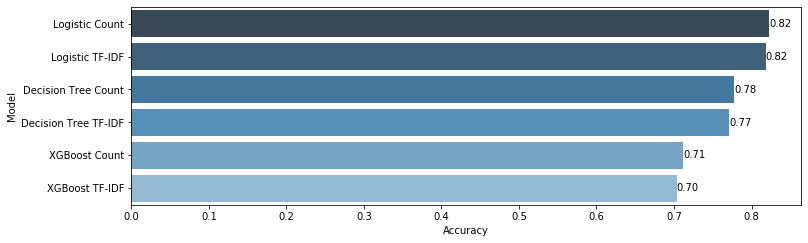

In [69]:
compare = pd.DataFrame({"Model": ["Logistic Count", "Logistic TF-IDF", 
                                  "XGBoost Count","XGBoost TF-IDF", 
                                  "Decision Tree Count","Decision Tree TF-IDF"],
                        "Accuracy": [log_model_accuracy_count, log_model_accuracy_tf_idf,
                                     xgb_model_accuracy_count, xgb_model_accuracy_tf_idf,
                                     tree_model_accuracy_count, tree_model_accuracy_tf_idf]})
def labels(ax):
    for p in ax.patches:
        width = p.get_width()    # get bar length
        ax.text(width,       # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
                '{:1.2f}'.format(width), # set variable to display, 2 decimals
                ha = 'left',   # horizontal alignment
                va = 'center')  # vertical alignment
plt.figure(figsize=(12,8))
plt.subplot(211)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.show()

**Second way**

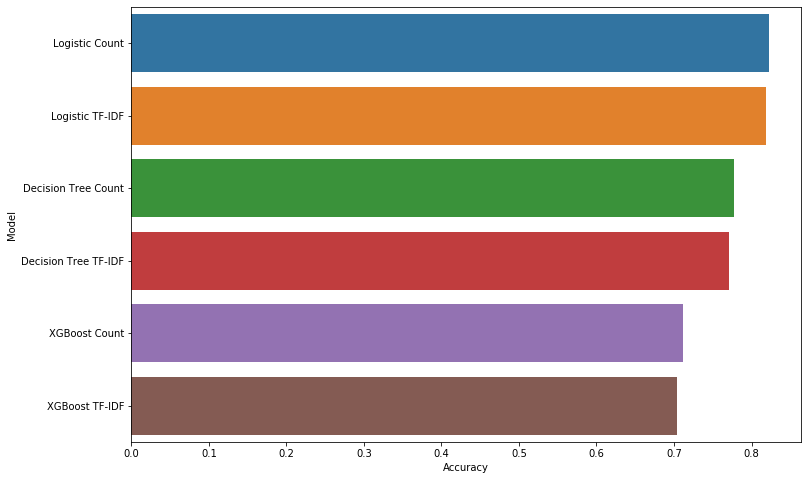

In [70]:
compare = compare = pd.DataFrame({"Model": ["Logistic Count", "Logistic TF-IDF", "XGBoost Count", "XGBoost TF-IDF", "Decision Tree Count","Decision Tree TF-IDF"],
                        "Accuracy": [log_model_accuracy_count, log_model_accuracy_tf_idf, xgb_model_accuracy_count, xgb_model_accuracy_tf_idf,tree_model_accuracy_count, tree_model_accuracy_tf_idf]})

compare = compare.sort_values(by="Accuracy", ascending=False)

plt.figure(figsize=(12,8))
ax = sns.barplot(x="Accuracy", y="Model", data=compare)